## 4. Training a Classifier

#### Importing libraries

In [14]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

#### Table of content:

* [Introduction](#intro)
    * [CIFAR10 Dataset](#cifar10)
* [Data Importing](#data)
    * [Build data transformer](#transformer)
    * [Loading the dataset](#loader)
    * [Visualizing the dataset](#visualizing)
* [Defining a Convolution Neural Network](#cnn)
* [Defining a loss function and optimizer](#loss_optimizer)
* [Training the network](#training)
* [Testing the network](#testing)
    * [Visualizing the dataset](#visualizing_test) 
    * [Getting output for test set](#output_test)
    * [Getting accuracy of the network](#accuracy_test)
    * [Getting accuracy of the network for each class](#accuracy_test_class)
* [Training on GPU](#GPU)

## Introduction <a class="anchor" id="intro"></a>

What about data?

    We can use standard python packages that load data into a numpy array. Then you can convert this array into a torch.*Tensor
    
    For images: Pillow, OpenCV 
    For audio: scipy & librosa
    For text: raw Python, Cython or NLTK or Spacy
    
Specifically for vision, pytorch has the package `torchvision`, `torchvision.datasets` and `torch.utils.data.DataLoader` that has:
    
    - data loaders for common datasets like Imagenet, CIFAR10, MNIST 
    - data transfomers for images, viz 

#### CIFAR10 Dataset <a class="anchor" id="cifar10"></a>

This dataset consists of 10 labels:
    - airplane 
    - automobile 
    - bird 
    - cat 
    - deer 
    - dog 
    - frog 
    - horse 
    - ship 
    - truck

The images are 3 x 32 x 32 : 3 channels of the colour images, with 32 x 32 pixels in size

<img src="../images/beginner/cifar10.png"></img>

## Data <a class="anchor" id="data"></a>

    The output of torchvision datasets are PILImage images of range [0,1]. We can transform them to Tensors of normalized range [-1,1]
    
    We can use the function transforms.Normalize(mean,std)
        - In this case, we have a tuple with 3 elements for mean & std each
        - The value corresponds to each of the channels (3 channels)
        

#### Building data transformer <a class="anchor" id="transformer"></a>

In [2]:
# 2 Steps for transformation: 
    # 1. Transform to tensor 
    # 2. Normalize it to -1, 1 

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

#### Download & Load the data <a class="anchor" id="loader"></a>

In [3]:
# <------------------------------------ TRAIN SET ------------------------------------>

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform) # If already downloaded, it will not download again

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2) # Returns a generator

# <------------------------------------- TEST SET ------------------------------------>

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# <----------------------------------- THE CLASSES ------------------------------------> 

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#### Visualizing the dataset (JUST FOR FUN) <a class="anchor" id="visualizing"></a>

In [9]:
def show_image(img):
    img = (img /2) + 0.5 # Unnormalizing the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))


 frog   car   car   dog


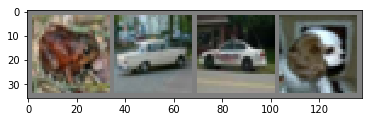

In [10]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
show_image(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Defining a Convolution Neural Network <a class="anchor" id="cnn"></a>

In [12]:
class Net(nn.Module): # Our definition is the child of the parent class nn.module
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3,6,5) # 3 input image channel, 6 output channels, 5*5 square convolution kernel
        self.pool = nn.MaxPool2d(2,2)
        
        self.conv2 = nn.Conv2d(6,16,5) # 6 input channels
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    
    def forward(self, x): # Does a max pooling over a (2,2) window 
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 
        

#### Initialize a Neural Network

In [13]:
net = Net()

## Defining a Loss function and optimizer <a class="anchor" id="loss_optimizer"></a>

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # Learning rate & momentum 

## Training the network <a class="anchor" id="training"></a>

In [22]:
for epoch in range(2):
    
    running_loss = 0.0 
    
    for i, data in enumerate(trainloader,0):
        
        inputs, labels = data
        
        optimizer.zero_grad() #Make sure we zero off the gradients from the previous iteration / mini-batch 
        
        outputs = net(inputs) # Get the output
        loss = criterion(outputs, labels)  # Calculate the log loss 
        loss.backward() # Backprop
        optimizer.step() # Update the weights 
        
        running_loss += loss.item()
        
        obs = 2000
        
        if (i+1)%obs == 0:
            print("epoch = %d, batch = %5d, loss = %3f"%(epoch+1, i+1, running_loss/obs))
            running_loss = 0.0
    print()
print("Done training!")

epoch = 1, batch =  2000, loss = 0.815188
epoch = 1, batch =  4000, loss = 0.861606
epoch = 1, batch =  6000, loss = 0.866463
epoch = 1, batch =  8000, loss = 0.884107
epoch = 1, batch = 10000, loss = 0.882410
epoch = 1, batch = 12000, loss = 0.895574

epoch = 2, batch =  2000, loss = 0.773350
epoch = 2, batch =  4000, loss = 0.808182
epoch = 2, batch =  6000, loss = 0.830177
epoch = 2, batch =  8000, loss = 0.851100
epoch = 2, batch = 10000, loss = 0.872624
epoch = 2, batch = 12000, loss = 0.857519

Done training!


## Testing the network <a class="anchor" id="testing"></a>

#### Visualizing the dataset <a class="anchor" id="visualizing_test"></a>

GroundTruth:    cat  ship  ship plane


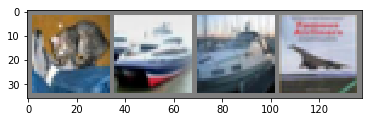

In [30]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
show_image(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### Getting output from the network <a class="anchor" id="output_teset"></a>

In [31]:
outputs = net(images) # Getting the output from the network

#### Getting the class labels (Max value)

In [36]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   dog   car horse


#### Getting the accuracy of the network <a class="anchor" id="accuracy_test"></a>

In [50]:
correct = 0
total = 0

# Wraps the execution in torch.no_grad() so that the computation is not tracked
with torch.no_grad():
    for data in testloader:
        images, labels = data # There are 4 images and 4 labels because our batch size is 4
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # Adds 4 : labels.size() is torch.Size([4])
        # (predicted == labels) gives a tensor of 1,0 (binary), we then sum and use .item() to get the value
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 63 %


#### Getting the accuracy of the network for each class <a class="anchor" id="accuracy_test_class"></a>

In [35]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 59 %
Accuracy of   car : 86 %
Accuracy of  bird : 54 %
Accuracy of   cat : 39 %
Accuracy of  deer : 59 %
Accuracy of   dog : 58 %
Accuracy of  frog : 70 %
Accuracy of horse : 66 %
Accuracy of  ship : 82 %
Accuracy of truck : 61 %


## Training on GPU <a class="anchor" id="GPU"></a>

#### Defining our device

We set the device to be `cuda:0` if we have GPU, else it would be `cpu`. `cuda:0` means the first GPU

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The device is: %s"%device)

The device is: cuda:0


#### Sending to GPU

We just have to send: 
    - The network 
    - The labels and the inputs 
to the GPU with the following functions:


In [53]:
net.to(device) # Network to the GPU
inputs, labels = inputs.to(device), labels.to(device)